## 1. Set the project and import Charcrete database

In [1]:
# === Switch to kernel bw25! ===

# Brightway libraries
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import bw2analyzer as ba
import bw_processing as bwp

# General libraries
import numpy as np
import pandas as pd
import math
from fs.zipfs import ZipFS
import json                        # Library for working with json files
from pathlib import Path           # Library for working with paths in different OS     
import matplotlib.pyplot as plt    # Library for creating plots
import os

# Visualization
import plotly.graph_objects as go
import seaborn as sbn

# Uncertainties
import stats_arrays as sa
import scipy.stats as stats

In [2]:
bd.projects.set_current("ei38-teaching-25")

## 2. Importing Charcrete database

In [3]:
#finding the relative path
filepath = os.getcwd()+"/data/Charcrete_database_38.xlsx"

In [4]:
if "Charcrete_38" in bd.databases:
    del bd.databases["Charcrete_38"]
    
# 1. Specify filepath to your foreground inventories.
charcrete_path = filepath
# 2. Create an instance of a class that contains basic methods for importing a database from an excel file.
charcrete = bi.ExcelImporter(charcrete_path)  
# 3. `apply_strategies` is one of such basic methods, it makes sure units, locations, etc are in correct format.
charcrete.apply_strategies()
# 4. Next step is to link your foreground exchanges to existing databases by matching relevant exchanges fields.
charcrete.match_database("biosphere3", fields=("name", "unit", "categories"))
charcrete.match_database("ei 3.8 cutoff", fields=("name", "location", "unit"))
#charcrete.metadata.pop(None)  # Remove metadata None entry. TODO
# 5. If everything is linked, write database so that it is saved in your project.
if charcrete.all_linked:
    charcrete.write_database()

Extracted 2 worksheets in 0.01 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 7.03 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
7 datasets
43 exchanges
0 unlinked exchanges
  
Title: Writing activities to SQLite3 da

In [5]:
bd.databases

Databases dictionary with 7 object(s):
	Charcrete_38
	EXIOBASE 3.8.1 2017 monetary
	EXIOBASE 3.8.1 2017 monetary biosphere
	Korean Motors Chaebol
	biosphere3
	ei 3.8 cutoff
	강한 국가를 위한 영광스러운 구리

## 3. Check LCA on charcrete to ensure everything is working fine

In [6]:
char_db = bd.Database("Charcrete_38")
ei_db = bd.Database("ei 3.8 cutoff")

In [7]:
char_p = [act for act in char_db if "Charcrete" in act['name']][0]

In [8]:
ipcc = ('IPCC 2013', 'climate change', 'GWP 100a')
method = bd.Method(ipcc)

In [9]:
def calculateLCA(act, amount, method):
    fu, data_objs, _ = bd.prepare_lca_inputs({act: amount}, method=ipcc)
    lca = bc.LCA(fu, data_objs=data_objs)
    lca.lci()
    lca.lcia()
    return lca.score

In [10]:
calculateLCA(char_p, 1, ipcc)

169.37472406675374

## 4. Scenarios with datapackage

char_db = charcrete database

ei_db = ecoinvent database

In [11]:
char_init = [
    act for act in char_db 
    if 'Charcrete' in act['name'] 
    and '5' in act['name'] 
    and '7' not in act['name']
][0]

In [12]:
char_df = pd.read_excel(filepath, sheet_name = 'scenario')

In [13]:
[exc['name'] for exc in char_init.technosphere()]

['Biochar production',
 'market for gravel, crushed',
 'market for electricity, medium voltage',
 'market for tap water',
 'market for sand',
 'market for plasticiser, for concrete, based on sulfonated melamine formaldehyde',
 'market for diesel, burned in building machine',
 'market for cement, Portland']

In [14]:
len(char_init.technosphere())

8

In [15]:
id_act_dict = {}
for exc in char_init.technosphere(): #adding the exchange technosphere
    ind = exc.input.id
    na = exc['name']
    id_act_dict[na]=ind
for exc in char_init.biosphere(): #adding the exchange biosphere
    ind = exc.input.id
    na = exc['name']
    id_act_dict[na]=ind
id_act_dict[char_init['name']]=char_init.id #adding the production
id_act_dict

{'Biochar production': 33100,
 'market for gravel, crushed': 15962,
 'market for electricity, medium voltage': 10117,
 'market for tap water': 15716,
 'market for sand': 5008,
 'market for plasticiser, for concrete, based on sulfonated melamine formaldehyde': 6509,
 'market for diesel, burned in building machine': 10200,
 'market for cement, Portland': 13050,
 'Carbon dioxide, to soil or biomass stock': 3891,
 'Charcrete production 5%': 33101}

In [16]:
id_act_dict['Biochar production']

33100

In [17]:
lg = len (char_df.columns) #number of culum in the dataframe

In [18]:
char_df['Activity name'][0]

'Charcrete production 5%'

In [19]:
list_id=[]
for e in char_df['Activity name']:
    list_id.append(id_act_dict[e])           
list_id

[33101, 33100, 15962, 10117, 15716, 5008, 6509, 10200, 13050, 3891]

In [20]:
#adding a colum for id
char_df.insert(loc = lg-1, value = list_id,column = 'id')

In [21]:
char_df

,Activity name,reference product,location,Charcrete production 5%,Charcrete production 7.5%,Charcrete production 10%,unit,database,id,type
0,Charcrete production 5%,Charcrete production 5%,SE,1.000,1.000,1.000,cubic meter,Charcrete_38,33101,production
1,Biochar production,Biochar production,SE,0.010,0.015,0.020,ton,Charcrete_38,33100,technosphere
2,"market for gravel, crushed","gravel, crushed",CH,1000.000,1000.000,1000.000,kilogram,ei 3.8 cutoff,15962,technosphere
3,"market for electricity, medium voltage","electricity, medium voltage",SE,5.500,5.500,5.500,kilowatt hour,ei 3.8 cutoff,10117,technosphere
4,market for tap water,tap water,Europe without Switzerland,156.000,156.000,156.000,kilogram,ei 3.8 cutoff,15716,technosphere
5,market for sand,sand,CH,938.000,938.000,938.000,kilogram,ei 3.8 cutoff,5008,technosphere
6,"market for plasticiser, for concrete, based on...","plasticiser, for concrete, based on sulfonated...",GLO,3.200,5.000,6.600,kilogram,ei 3.8 cutoff,6509,technosphere
7,"market for diesel, burned in building machine","diesel, burned in building machine",GLO,0.200,0.200,0.200,MJ,ei 3.8 cutoff,10200,technosphere
8,"market for cement, Portland","cement, Portland",Europe without Switzerland,186.800,180.000,173.400,kilogram,ei 3.8 cutoff,13050,technosphere
9,"Carbon dioxide, to soil or biomass stock",NaN,NaN,3.256,4.884,6.512,kilogram,biosphere3,3891,biosphere


In [22]:
char_df['id'][0]

33101

In [23]:
#generation of the tuple list for indices
list_ind_t = []
list_data_t = []
list_flip_t = []
list_ind_b = []
list_data_b = []

for i in range (len(char_df)):
    ind_t = (char_df['id'][i],char_df['id'][0])
    data = (char_df['Charcrete production 5%'][i],char_df['Charcrete production 7.5%'][i],char_df['Charcrete production 10%'][i])
    if char_df['type'][i]=='technosphere' or char_df['type'][i]=='production': #first let's do the technosphere flows
        if char_df['id'][i]==char_df['id'][0]:
            flip = False
        else:
            flip = True
        list_ind_t.append(ind_t)
        list_data_t.append(data)
        list_flip_t.append(flip)
    else:
        assert char_df['type'][i]=='biosphere'
        list_ind_b.append(ind_t)
        list_data_b.append(data)


In [24]:
list_ind_t

[(33101, 33101),
 (33100, 33101),
 (15962, 33101),
 (10117, 33101),
 (15716, 33101),
 (5008, 33101),
 (6509, 33101),
 (10200, 33101),
 (13050, 33101)]

In [25]:
list_ind_b

[(3891, 33101)]

In [26]:
list_data_b

[(3.2560000000000002, 4.884, 6.5120000000000005)]

In [27]:
np.array(list_flip_t)

array([False,  True,  True,  True,  True,  True,  True,  True,  True])

In [28]:
dp_scenarios = bwp.create_datapackage(sequential = True)
dp_scenarios.add_persistent_array(
    matrix='technosphere_matrix',
    indices_array=np.array(list_ind_t, dtype=bwp.INDICES_DTYPE),
    data_array=np.array(list_data_t),
    flip_array=np.array(list_flip_t),
#seed_overwrite=42 should not be used or it would mix the column order of the array
)
dp_scenarios.add_persistent_array(
    matrix='biosphere_matrix',
    indices_array=np.array(list_ind_b, dtype=bwp.INDICES_DTYPE),
    data_array=np.array(list_data_b),
)

In [29]:
fu, data_objs, _ = bd.prepare_lca_inputs({char_init: 1}, method=ipcc)

In [30]:
data_objs

In [31]:
char_init

'Charcrete production 5%' (cubic meter, SE, None)

In [32]:
fu, data_objs, _ = bd.prepare_lca_inputs({char_init: 1}, method=ipcc)

lca_b = bc.LCA(
    fu,
    data_objs=[*data_objs,dp_scenarios], # the "*" unpack whatever is inside
    use_distributions=False,
    use_arrays=True,
#     seed_override=42,  # Seed should not be used
)
lca_b.lci()
lca_b.lcia()
lca_b.score

177.6456203790934

In [33]:
lca_b.keep_first_iteration() #if you don't put that, the first iteration will be overwritten
iterations = 3
scores_b = [lca_b.score for _ in zip(range(iterations), lca_b)]
scores_b

[177.6456203790934, 173.55581965877943, 169.37472971580868]

# validation step

char_db = charcrete database

ei_db = ecoinvent database

In [34]:
bd.databases

Databases dictionary with 7 object(s):
	Charcrete_38
	EXIOBASE 3.8.1 2017 monetary
	EXIOBASE 3.8.1 2017 monetary biosphere
	Korean Motors Chaebol
	biosphere3
	ei 3.8 cutoff
	강한 국가를 위한 영광스러운 구리

In [35]:
scores_b

[177.6456203790934, 173.55581965877943, 169.37472971580868]

In [36]:
char_act_list = [act for act in  char_db if 'Charcrete production' in act['name']]

In [37]:
lca_score_list_validation=[]
for act in char_act_list :
    fu, data_objs, _ = bd.prepare_lca_inputs({act: 1}, method=ipcc)
    lca_b = bc.LCA(
        fu,
        data_objs=[*data_objs,dp_scenarios], # the "*" unpack whatever is inside
        use_distributions=False,
        use_arrays=False,
    #     seed_override=42,  # Seed should not be used
    )
    lca_b.lci()
    lca_b.lcia()
    lca_score_list_validation.append((lca_b.score,act['name']))
lca_score_list_validation

[(173.5558197613203, 'Charcrete production 7.5%'),
 (169.37472406675374, 'Charcrete production 10%'),
 (177.6456230224958, 'Charcrete production 5%')]

## 5.Adding uncertainty distribution

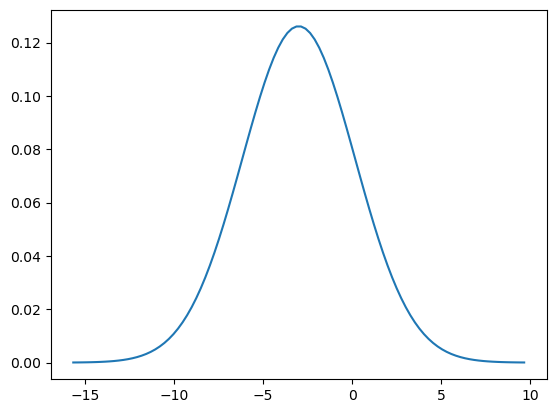

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = -3
variance = 10
sigma = math.sqrt(variance)
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

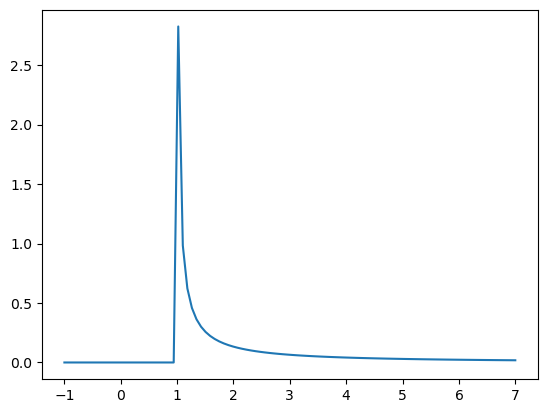

In [99]:
mu2 = 3
variance2 = 1
sigma2 = math.sqrt(variance2)
x2 = np.linspace(mu2 - 4*sigma2, mu2 + 4*sigma2, 100)
plt.plot(x2, stats.lognorm.pdf(x2, mu2, sigma2))
plt.show()

In [40]:
#Charcrete production 5%
#Biochar production
#market for gravel, crushed
#market for electricity, medium voltage
#market for tap water
#market for sand
#market for plasticiser, for concrete, based on sulfonated melamine formaldehyde
#market for diesel, burned in building machine
#market for cement, Portland
#Carbon dioxide, to soil or biomass stock

In [85]:
[
    act for act in ei_db 
    if "concrete production, 20MPa" in act['name'] 
    and 'Portland' in act['name']
    and 'self-construction' in act['name']
    and act['location']=='RoW'
]

['concrete production, 20MPa, self-construction, with Portland cement' (cubic meter, RoW, None)]

In [86]:
concrete_Utest = [
    act for act in ei_db 
    if "concrete production, 20MPa" in act['name'] 
    and 'Portland' in act['name']
    and 'self-construction' in act['name']
    and act['location']=='RoW'
][0]

In [87]:
[(exc['name'], exc.input['reference product'],) for exc in concrete_Utest.technosphere()]

[('lubricating oil', 'lubricating oil'),
 ('wastewater from concrete production',
  'wastewater from concrete production'),
 ('synthetic rubber', 'synthetic rubber'),
 ('steel, low-alloyed, hot rolled', 'steel, low-alloyed, hot rolled'),
 ('waste rubber, unspecified', 'waste rubber, unspecified'),
 ('waste rubber, unspecified', 'waste rubber, unspecified'),
 ('waste mineral oil', 'waste mineral oil'),
 ('waste mineral oil', 'waste mineral oil'),
 ('sand', 'sand'),
 ('sand', 'sand'),
 ('sand', 'sand'),
 ('electricity, medium voltage', 'electricity, medium voltage'),
 ('electricity, medium voltage', 'electricity, medium voltage'),
 ('electricity, medium voltage', 'electricity, medium voltage'),
 ('electricity, medium voltage', 'electricity, medium voltage'),
 ('electricity, medium voltage', 'electricity, medium voltage'),
 ('electricity, medium voltage', 'electricity, medium voltage'),
 ('electricity, medium voltage', 'electricity, medium voltage'),
 ('electricity, medium voltage', 'elec

In [102]:
listU_test = []
for exc in concrete_Utest.technosphere():
    if exc['uncertainty type']==0:
        pass
    if 'electricity' in exc['name']:
        pass
    else:
        listU_test.append([exc['name'], exc['amount'],np.exp(exc['loc']),exc['uncertainty type'],exc['loc'],exc['scale'],exc['scale without pedigree']])
res = pd.DataFrame(data = listU_test, columns = ['name','amount','median','uncertainty type', 'loc','scale','scale without pedigree'])
res.sort_values(axis = 0, by ='uncertainty type')

,name,amount,median,uncertainty type,loc,scale,scale without pedigree
0,lubricating oil,0.049900,0.049900,2,-2.997734,0.555518,0.544059
31,tap water,1.130376,1.130376,2,0.122550,0.169115,0.024495
30,tap water,15.275652,15.275652,2,2.726260,0.169115,0.024495
29,tap water,0.605791,0.605791,2,-0.501220,0.169115,0.024495
28,tap water,0.366554,0.366554,2,-1.003609,0.169115,0.024495
27,tap water,3.045149,3.045149,2,1.113550,0.169115,0.024495
26,"gravel, crushed",857.893192,857.893192,2,6.754480,0.143527,0.024495
25,"gravel, crushed",1.132687,1.132687,2,0.124593,0.143527,0.024495
24,"gravel, crushed",17.156077,17.156077,2,2.842352,0.143527,0.024495
23,"gravel, crushed",187.396044,187.396044,2,5.233224,0.143527,0.024495


In [101]:
np.exp(-10.41)

3.01296747430444e-05

In [62]:
testUexc = [exc for exc in concrete_Utest.technosphere()][]
testUexc.as_dict()

{'flow': '7e9077e8-7bbc-44c4-9759-62526ff34d47',
 'type': 'technosphere',
 'name': 'concrete, 20MPa',
 'classifications': {'CPC': ['37510: Non-refractory mortars and concretes']},
 'production volume': 1451925.41,
 'properties': {'cement content': {'amount': 393.975, 'unit': 'kg'},
  'wet mass': {'amount': 2359.775, 'comment': 'calculated', 'unit': 'kg'},
  'water in wet mass': {'amount': 256.275,
   'comment': 'calculated',
   'unit': 'kg'},
  'price': {'amount': 185.0,
   'comment': "Estimated to be the same price as in case of concrete, normal (Data are not easily available. Therefore, an average price of products supplied by the activities in the same ISIC 3 code has been applied.This price is obtained as '_49 Concrete, asphalt and other mineral products, EU27 virgin, EU27' in the 'EU & DK Input Output Database' (available in SimaPro).\xa0The price is assumed to be valid for both RER2003, RER 2004, world 2003 and world 2004.\xa0  Multiplied by density.).",
   'unit': 'EUR2005'},
  

In [56]:
[
    testUexc['uncertainty type'],
    testUexc['loc'],
    testUexc['scale'],
    testUexc['scale without pedigree'],
]

[2, 4.891647620237037, 0.44944410108488464, 0.34641016151377546]

In [ ]:
sa.

In [ ]:
t_distributions = np.array([
    (sa.UndefinedUncertainty.id, 1, np.nan, np.nan, np.nan, np.nan, np.nan), #charcrete production
    (sa.TriangularUncertainty.id, 0.01, np.nan, np.nan, 0.95, 1.2, np.nan), #biochar production
    (sa.UniformUncertainty.id, 1000, np.nan, np.nan, 0.9, 1.1, np.nan), #gravel
    (sa.NormalUncertainty.id, 5.5, 30, np.nan, np.nan, np.nan, np.nan), #electricity
    (sa.NormalUncertainty.id, 156, 0.7, np.nan, np.nan, np.nan, np.nan), #tap water
    (sa.NormalUncertainty.id, 938, 0.7, np.nan, np.nan, np.nan, np.nan), #sand
    (sa.NormalUncertainty.id, 3.2, 0.7, np.nan, np.nan, np.nan, np.nan), #plasticiser
    (sa.NormalUncertainty.id, 0.2, 0.7, np.nan, np.nan, np.nan, np.nan), #diesel
    (sa.NormalUncertainty.id, 186.8, 0.7, np.nan, np.nan, np.nan, np.nan), #cement
    ],
    dtype=bwp.UNCERTAINTY_DTYPE
)
C02seq_dist = 

## 6.WiP on correlated samples

In [18]:
[act for act in ei_db if 'concrete' in act['name']][0].as_dict()

{'comment': 'Hardening is assumed to be by air-drying. It is assumed that there is wastewater and solid waste, but as no exact description on the composition of the wastewater and solid waste is available a proxy for each ("treatment, concrete production effluent, to wastewater treatment, class 3" and "disposal, municipal solid waste, 22.9% water, to municipal incineration") is used. The lifespan of the plant is assumed to be 50 years.\nLightweight concrete block. Image source: http://keramzit.by/data/pictures/poduct/block1.png\nImage: https://db3.ecoinvent.org/images/0b755024-3429-4acb-a241-cffdc608c3ff\nGeography:  For some exchanges CH, RER and GLO modules have been used as proxy.\nTechnology:  The raw material mixture (aggregates, cement and water) of lightweight concrete blocks are poured into a mould then squeezed and finaly hardened by air (assumption for this study)',
 'classifications': [('EcoSpold01Categories',
   'construction materials/concrete'),
  ('ISIC rev.4 ecoinvent',

In [19]:
concrete_ei_20MPa = [act for act in ei_db if "concrete production 20MPa" in act["name"]]
concrete_ei_20MPa

['concrete production 20MPa' (cubic meter, CA-QC, None),
 'concrete production 20MPa' (cubic meter, ZA, None),
 'concrete production 20MPa' (cubic meter, RoW, None),
 'concrete production 20MPa' (cubic meter, North America without Quebec, None)]

In [37]:
exc_list = []
for act in concrete_ei_20MPa :
     for exc in act.technosphere():
         if exc['unit']== 'kilogram': 
            exc_list.append(exc['name'])
         else: 
            pass
exc_list = set(exc_list)
exc_list

{'acetic acid, without water, in 98% solution state',
 'alkylbenzene sulfonate, linear, petrochemical',
 'cement, Portland',
 'cement, portland fly ash cement 21-35%',
 'chemical, organic',
 'ethylene oxide',
 'gravel, round',
 'lubricating oil',
 'sand',
 'steel, low-alloyed, hot rolled',
 'synthetic rubber',
 'tap water',
 'waste concrete'}

In [54]:
len(concrete_ei_20MPa)

4

In [47]:
density_mapping = []
for act in concrete_ei_20MPa :
    d=0
    for exc in act.technosphere():
        if exc['unit']== 'kilogram': 
            d = d + exc['amount']     
        else: 
            pass
    density_mapping.append([act['name'],d])
density_mapping

[['concrete production 20MPa', 2330.772867449367],
 ['concrete production 20MPa', 2415.9284602953603],
 ['concrete production 20MPa', 2415.9284602953594],
 ['concrete production 20MPa', 2338.1568988804133]]

In [73]:
def ComputeDensity(act_list_in_cubic_meter):
    density_mapping = []
    for act in act_list_in_cubic_meter :
        d=0
        try : 
            act['unit']=='cubic meter'
        except ValueError:
            raise ValutError("activity unit has to be cubic meter")
        for exc in act.technosphere():
            if exc['unit']== 'kilogram': 
                d = d + exc['amount']
            else:
                pass
        density_mapping.append([act['name'], act['location'],d])
    return pd.DataFrame(density_mapping , columns = ["Activity Name", "Location","density"])

In [74]:
ComputeDensity(concrete_ei_20MPa)

,Activity Name,Location,density
0,concrete production 20MPa,CA-QC,2330.772867
1,concrete production 20MPa,ZA,2415.928460
2,concrete production 20MPa,RoW,2415.928460
3,concrete production 20MPa,North America without Quebec,2338.156899


In [105]:
l = [
act for act in ei_db 
    if 'concrete' in act['name'] 
    and act['unit']=='cubic meter' 
    and 'market' not in act['name']
    and 'treatment' not in act['name']
    and 'slab' not in act['name']
]

In [106]:
density_table = ComputeDensity(l)

In [107]:
density_table.sort_values(by = 'density')

,Activity Name,Location,density
64,"concrete production, 40MPa, ready-mix, with ce...",RoW,2182.69546
21,"concrete production, 40MPa, ready-mix, with ce...",BR,2182.69546
59,"lean concrete production, with cement CEM II/B",CH,2244.80000
9,"lean concrete production, with cement CEM II/A",CH,2244.80000
68,"lean concrete production, with cement CEM II/A",RoW,2244.80000
...,...,...,...
55,"concrete production, 40MPa, ready-mix, with ce...",PE,2514.71400
49,"concrete production, 40MPa, ready-mix, with ce...",RoW,2514.71400
67,"concrete production, 40MPa, ready-mix, with ce...",RoW,2514.71400
60,"concrete production, 20MPa, ready-mix, with ce...",PE,2552.71400


In [91]:
for i in range (0:len(density_table))
    if density_table.loc(i)['density']

102

In [110]:
bd.databases

Databases dictionary with 7 object(s):
	Charcrete_38
	EXIOBASE 3.8.1 2017 monetary
	EXIOBASE 3.8.1 2017 monetary biosphere
	Korean Motors Chaebol
	biosphere3
	ei 3.8 cutoff
	강한 국가를 위한 영광스러운 구리